In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
import tensorflow as tf
gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:    
#     for gpu in gpus:
#         tensorflow.config.set_logical_device_configuration(
#             gpu,
#             [tensorflow.config.LogicalDeviceConfiguration(memory_limit=48*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data_list = []
    y_data_list = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            with np.load(file_path) as data:
                X_data_list.append(data['X'])
                y_data_list.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data_list)
    y_data = np.hstack(y_data_list)
    
    return X_data, y_data

# Define the folder containing your preprocessed .npz files
data_folder = '/home/rl_sim/thesis_ws/src/ML_ACTIONS/DATA/FLAP_HYB_1FTP_2FT_ScalNorm'

# Load the dataset
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)  # Should print the shape as (samples, time steps, features)
print("y_data shape:", y_data.shape)  # Should print the shape as (samples,)
print("X_data[0] shape:", X_data[0].shape)  # Should print the shape as (time steps, features)

# Split the data into training, validation, and test sets
TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print information about the dataset splits
print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

# Define the dimensions based on your scaleogram dimensions and window size
scales_dim = 128
target_length = 1800
num_1D_features = 9
num_2D_signals = 6  # Number of 2D signals (e.g., Force_X, Force_Y, Force_Z, Torque_X, Torque_Y, Torque_Z)
num_classes = int(np.max(y_data)) + 1  # Number of classes

# Separate 1D and 2D data
X_train_1D = X_train[:, :, :num_1D_features]  # First 9 features
X_val_1D = X_val[:, :, :num_1D_features]
X_test_1D = X_test[:, :, :num_1D_features]

X_train_2D = X_train[:, :, num_1D_features:].reshape(-1, target_length, scales_dim * num_2D_signals)
X_val_2D = X_val[:, :, num_1D_features:].reshape(-1, target_length, scales_dim * num_2D_signals)
X_test_2D = X_test[:, :, num_1D_features:].reshape(-1, target_length, scales_dim * num_2D_signals)


# Print the shapes of the 1D and 2D data
print("X_train_1D shape:", X_train_1D.shape)  # Should print something like (samples, target_length, 9)
print("X_val_1D shape:", X_val_1D.shape)
print("X_test_1D shape:", X_test_1D.shape)

print("X_train_2D shape:", X_train_2D.shape)  # Should print something like (samples, target_length, scales_dim, 1)
print("X_val_2D shape:", X_val_2D.shape)
print("X_test_2D shape:", X_test_2D.shape)

# Example to print shapes of individual data points
print("X_train_1D[0] shape:", X_train_1D[0].shape)  # Should print (target_length, 9)
print("X_train_2D[0] shape:", X_train_2D[0].shape)  # Should print (target_length, scales_dim, 1)
OUT_N = num_classes  # Calculate the number of classes
DISP_LABELS = list(range(OUT_N))  # Create a list of labels from 0 to OUT_N-1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)

# 777 = 9 + 128*6


def compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, batch_size=32, patience=8, disp_labels=DISP_LABELS):
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)

    # Predict labels for test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    FontSz = 2.5

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot Loss Value
    axs[0].plot(history.history["loss"], label="loss (Training)", linewidth=FontSz)
    axs[0].plot(history.history["val_loss"], label="val_loss",linewidth=FontSz)
    axs[0].set_title("Loss Value")
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history["accuracy"], label="accuracy" ,linewidth=FontSz)
    axs[1].plot(history.history["val_accuracy"], label="val_accuracy" ,linewidth=FontSz)
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred_labels, average='macro') 
    accuracy = accuracy_score(y_test, y_pred_labels)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred_labels))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=disp_labels, )
    disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
    for text in disp.text_.ravel():
        text.set_fontsize(14)  # Set font size (adjust number as needed)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return history, loss, accuracy, f1, y_pred_labels

2024-09-13 16:10:15.095501: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-13 16:10:15.120850: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 16:10:15.519667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-13 16:10:15.827127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more 

X_data shape: (537, 1800, 777)
y_data shape: (537,)
X_data[0] shape: (1800, 777)
TOTAL DATA: 537  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (322, 1800, 777)    ||  Dimensions of y_train: (322,)
Dimensions of X_test:  (108, 1800, 777)    ||  Dimensions of y_test:  (108,)
Dimensions of X_val:   (107, 1800, 777)    ||  Dimensions of y_val:   (107,)
X_train_1D shape: (322, 1800, 9)
X_val_1D shape: (107, 1800, 9)
X_test_1D shape: (108, 1800, 9)
X_train_2D shape: (322, 1800, 768)
X_val_2D shape: (107, 1800, 768)
X_test_2D shape: (108, 1800, 768)
X_train_1D[0] shape: (1800, 9)
X_train_2D[0] shape: (1800, 768)
OUT_N: 3
DISP_LABELS: [0, 1, 2]


## 2 BRANCHES new

2024-09-13 16:10:20.442240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-13 16:10:20.442388: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-13 16:10:20.442502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "TwoBranchModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1D            │ (None, 1800, 9)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2D            │ (None, 1800, 768, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1D (Conv1D)   │ (None, 1798, 64)  │      1,792 │ input_1D[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2D (Conv2D)   │ (None, 180, 77,   │     12,832 │ input_2D[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1798, 64)  │          0 │ conv1_1D[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 180, 77,   │          0 │ conv1_2D[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 899, 64)   │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 19,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1D (Conv1D)   │ (None, 897, 128)  │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2D (Conv2D)   │ (None, 9, 4, 64)  │    204,864 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 897, 128)  │          0 │ conv2_1D[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 9, 4, 64)  │          0 │ conv2_2D[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ activation_1[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ activation_3[0][… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     24,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]     

 Total params: 277,347 (1.06 MB)

 Trainable params: 277,347 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


I0000 00:00:1726236623.102562 2231058 service.cc:145] XLA service 0x7f048400e8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726236623.102618 2231058 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1726236623.102622 2231058 service.cc:153]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-13 16:10:23.131298: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-13 16:10:23.223575: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3499 - loss: 1.3125

I0000 00:00:1726236624.865987 2231058 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.3687 - loss: 1.2814 - val_accuracy: 0.4673 - val_loss: 1.2041
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5839 - loss: 0.8863 - val_accuracy: 0.3458 - val_loss: 1.7103
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5930 - loss: 0.8555 - val_accuracy: 0.6916 - val_loss: 0.7224
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7304 - loss: 0.5921 - val_accuracy: 0.6822 - val_loss: 0.6929
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7973 - loss: 0.4858 - val_accuracy: 0.6449 - val_loss: 0.9011
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7931 - loss: 0.4909 - val_accuracy: 0.7290 - val_loss: 0.6779
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8829 - loss: 0.3238 - val_accuracy: 0.7196 - val_loss: 0.7302
Epoch 8/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9071 - loss: 0.2515 - val_accuracy: 0.6355 - val_loss: 1

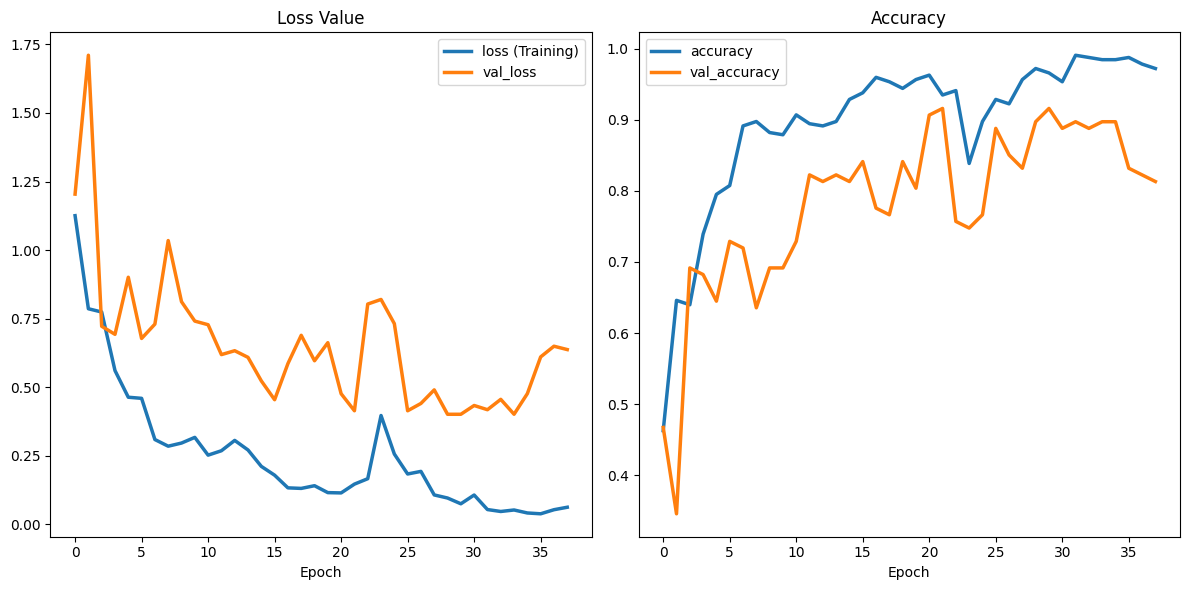

Test loss: 0.28937074542045593
Test accuracy: 0.8981481481481481
F1 Score: 0.9004185422095871
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.96        34
         1.0       1.00      0.80      0.89        40
         2.0       0.77      0.97      0.86        34

    accuracy                           0.90       108
   macro avg       0.91      0.90      0.90       108
weighted avg       0.92      0.90      0.90       108



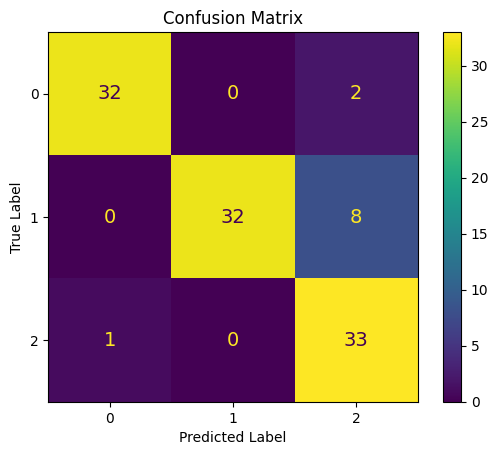

In [2]:
def build_TwoBranchModel(F_input_shape, S_input_shape, num_classes):
    # 1D Data Branch
    input_1D = tf.keras.layers.Input(shape=F_input_shape, name='input_1D')
    conv1_1D = tf.keras.layers.Conv1D(64, kernel_size=3, strides=1, name='conv1_1D')(input_1D)
    conv1_1D = tf.keras.layers.Activation('relu')(conv1_1D)
    pool1_1D = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1_1D)

    conv2_1D = tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, name='conv2_1D')(pool1_1D)
    conv2_1D = tf.keras.layers.Activation('relu')(conv2_1D)
    pool2_1D = tf.keras.layers.GlobalMaxPooling1D()(conv2_1D)

    flatten_1D = tf.keras.layers.Flatten()(pool2_1D)

    # 2D Data Branch (Scaleograms)
    input_2D = tf.keras.layers.Input(shape=S_input_shape, name='input_2D')
    conv1_2D = tf.keras.layers.Conv2D(32, kernel_size=(20, 20), strides=(10,10), padding='same', name='conv1_2D')(input_2D)
    conv1_2D = tf.keras.layers.Activation('relu')(conv1_2D)
    pool1_2D = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))(conv1_2D)

    conv2_2D = tf.keras.layers.Conv2D(64, kernel_size=(10, 10), strides=(5,5), padding='same', name='conv2_2D')(pool1_2D)
    conv2_2D = tf.keras.layers.Activation('relu')(conv2_2D)
    pool2_2D = tf.keras.layers.GlobalMaxPooling2D()(conv2_2D)

    flatten_2D = tf.keras.layers.Flatten()(pool2_2D)

    # Merge branches
    merged = tf.keras.layers.concatenate([flatten_1D, flatten_2D])

    # Fully Connected Layers
    fc = tf.keras.layers.Dense(128, activation='relu')(merged)
    fc = tf.keras.layers.Dense(64, activation='relu')(fc)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)

    # Define the Model
    model = tf.keras.Model(inputs=[input_1D, input_2D], outputs=output, name='TwoBranchModel')
    return model

F_input_shape = (target_length, 9)  # For the 1D branch (force, torque, and pose data)
S_input_shape = (target_length, scales_dim * num_2D_signals, 1)  # For the 2D branch (scaleograms)


_X_train = [X_train_1D, X_train_2D]
_X_val = [X_val_1D, X_val_2D]
_X_test = [X_test_1D, X_test_2D]

# Create and compile the model
model = build_TwoBranchModel(F_input_shape, S_input_shape, num_classes)
model.summary()
history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, _X_train, y_train, _X_val, y_val, _X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)


In [3]:
# print(f"y_pred: {y_pred_labels[8]}")
# layer_names = ['conv2_1D', 'conv2_2D']
# plot_grad_cam(model, [X_test_1D, X_test_2D], 8, y_test, layer_names)

## MANY BRANCHES

Model: "MultiBranchModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_forces_1D     │ (None, 1800, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_torques_1D    │ (None, 1800, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_deltaPoses_1D │ (None, 1800, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_forces_2D     │ (None, 1800, 384, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_torques_2D    │ (None, 1800, 384, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_forces_1D     │ (None, 177, 64)   │      7,744 │ input_forces_1D[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_torques_1D    │ (None, 177, 64)   │      7,744 │ input_torques_1D… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_deltaPoses_1D │ (None, 177, 64)   │      7,744 │ input_deltaPoses… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_forces_2D     │ (None, 180, 39,   │     25,664 │ input_forces_2D[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_torques_2D    │ (None, 180, 39,   │     25,664 │ input_torques_2D… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_44       │ (None, 177, 64)   │          0 │ conv1_forces_1D[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 177, 64)   │          0 │ conv1_torques_1D… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 177, 64)   │          0 │ conv1_deltaPoses… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 180, 39,   │          0 │ conv1_forces_2D[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_52       │ (None, 180, 39,   │          0 │ conv1_torques_2D… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 177, 64)   │          0 │ activation_44[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 177, 64)   │          0 │ activation_46[0]

 Total params: 2,295,619 (8.76 MB)

 Trainable params: 2,295,619 (8.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 730ms/step - accuracy: 0.3923 - loss: 1.3005 - val_accuracy: 0.4860 - val_loss: 1.1413
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5609 - loss: 1.0831 - val_accuracy: 0.6636 - val_loss: 0.7649
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7319 - loss: 0.5391 - val_accuracy: 0.7196 - val_loss: 0.7496
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7648 - loss: 0.5345 - val_accuracy: 0.7103 - val_loss: 0.8793
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7398 - loss: 0.5743 - val_accuracy: 0.6542 - val_loss: 0.9736
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8731 - loss: 0.2942 - val_accuracy: 0.6729 - val_loss: 0.8851
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8508 - loss: 0.3157 - val_accuracy: 0.7850 - val_loss: 0.7160
Epoch 8/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8929 - loss: 0.2697 - val_accuracy: 0.6355 -

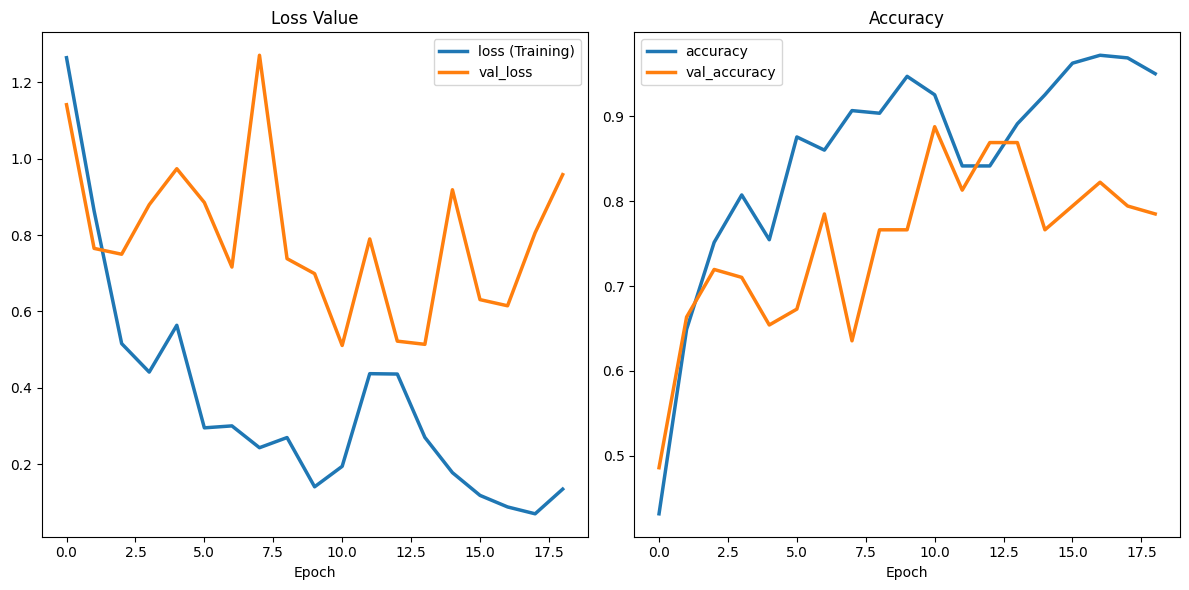

Test loss: 0.36685478687286377
Test accuracy: 0.8796296296296297
F1 Score: 0.8796099784909354
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        34
         1.0       0.97      0.75      0.85        40
         2.0       0.79      0.91      0.85        34

    accuracy                           0.88       108
   macro avg       0.89      0.89      0.88       108
weighted avg       0.89      0.88      0.88       108



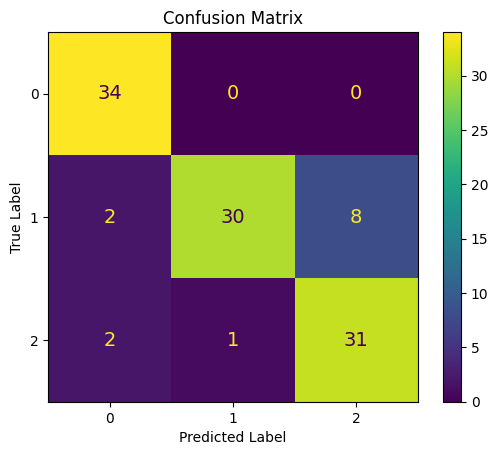

In [8]:
def build_MultiBranchModel(F_input_shape, T_input_shape, P_input_shape, S_input_shape_F, S_input_shape_T, num_classes):
    # 1D Force Branch
    input_forces_1D = tf.keras.layers.Input(shape=F_input_shape, name='input_forces_1D')
    conv1_forces_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_forces_1D')(input_forces_1D)
    conv1_forces_1D = tf.keras.layers.Activation('relu')(conv1_forces_1D)
    dropout1_forces_1D = tf.keras.layers.Dropout(0.1)(conv1_forces_1D)
    conv2_forces_1D = tf.keras.layers.Conv1D(128, kernel_size=20, strides=4, name='conv2_forces_1D')(dropout1_forces_1D)
    conv2_forces_1D = tf.keras.layers.Activation('relu')(conv2_forces_1D)
    dropout2_forces_1D = tf.keras.layers.Dropout(0.1)(conv2_forces_1D)
    pool1_forces_1D = tf.keras.layers.GlobalMaxPooling1D()(dropout2_forces_1D)

    flatten_forces_1D = tf.keras.layers.Flatten()(pool1_forces_1D)

    # 1D Torque Branch
    input_torques_1D = tf.keras.layers.Input(shape=T_input_shape, name='input_torques_1D')
    conv1_torques_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_torques_1D')(input_torques_1D)
    conv1_torques_1D = tf.keras.layers.Activation('relu')(conv1_torques_1D)
    dropout1_torques_1D = tf.keras.layers.Dropout(0.1)(conv1_torques_1D)
    conv2_torques_1D = tf.keras.layers.Conv1D(128, kernel_size=20, strides=4, name='conv2_torques_1D')(dropout1_torques_1D)
    conv2_torques_1D = tf.keras.layers.Activation('relu')(conv2_torques_1D)
    dropout2_torques_1D = tf.keras.layers.Dropout(0.1)(conv2_torques_1D)
    pool1_torques_1D = tf.keras.layers.GlobalMaxPooling1D()(dropout2_torques_1D)

    flatten_torques_1D = tf.keras.layers.Flatten()(pool1_torques_1D)

    # 1D Delta Pose Branch
    input_deltaPoses_1D = tf.keras.layers.Input(shape=P_input_shape, name='input_deltaPoses_1D')
    conv1_deltaPoses_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_deltaPoses_1D')(input_deltaPoses_1D)
    conv1_deltaPoses_1D = tf.keras.layers.Activation('relu')(conv1_deltaPoses_1D)
    dropout1_deltaPoses_1D = tf.keras.layers.Dropout(0.1)(conv1_deltaPoses_1D)
    conv2_deltaPoses_1D = tf.keras.layers.Conv1D(128, kernel_size=20, strides=4, name='conv2_deltaPoses_1D')(dropout1_deltaPoses_1D)
    conv2_deltaPoses_1D = tf.keras.layers.Activation('relu')(conv2_deltaPoses_1D)
    dropout2_deltaPoses_1D = tf.keras.layers.Dropout(0.1)(conv2_deltaPoses_1D)
    pool1_deltaPoses_1D = tf.keras.layers.GlobalMaxPooling1D()(dropout2_deltaPoses_1D)

    flatten_deltaPoses_1D = tf.keras.layers.Flatten()(pool1_deltaPoses_1D)

    # 2D Force Scaleogram Branch
    input_forces_2D = tf.keras.layers.Input(shape=S_input_shape_F, name='input_forces_2D')
    conv1_forces_2D = tf.keras.layers.Conv2D(64, kernel_size=(20, 20), strides=(10, 10), padding='same', name='conv1_forces_2D')(input_forces_2D)
    conv1_forces_2D = tf.keras.layers.Activation('relu')(conv1_forces_2D)
    dropout1_forces_2D = tf.keras.layers.Dropout(0.1)(conv1_forces_2D)
    conv2_forces_2D = tf.keras.layers.Conv2D(128, kernel_size=(10, 10), strides=(5, 5), padding='same', name='conv2_forces_2D')(dropout1_forces_2D)
    conv2_forces_2D = tf.keras.layers.Activation('relu')(conv2_forces_2D)
    dropout2_forces_2D = tf.keras.layers.Dropout(0.1)(conv2_forces_2D)
    pool1_forces_2D = tf.keras.layers.GlobalMaxPooling2D()(dropout2_forces_2D)

    flatten_forces_2D = tf.keras.layers.Flatten()(pool1_forces_2D)

    # 2D Torque Scaleogram Branch
    input_torques_2D = tf.keras.layers.Input(shape=S_input_shape_T, name='input_torques_2D')
    conv1_torques_2D = tf.keras.layers.Conv2D(64, kernel_size=(20, 20), strides=(10, 10), padding='same', name='conv1_torques_2D')(input_torques_2D)
    conv1_torques_2D = tf.keras.layers.Activation('relu')(conv1_torques_2D)
    dropout1_torques_2D = tf.keras.layers.Dropout(0.1)(conv1_torques_2D)
    conv2_torques_2D = tf.keras.layers.Conv2D(128, kernel_size=(10, 10), strides=(5, 5), padding='same', name='conv2_torques_2D')(dropout1_torques_2D)
    conv2_torques_2D = tf.keras.layers.Activation('relu')(conv2_torques_2D)
    dropout2_torques_2D = tf.keras.layers.Dropout(0.1)(conv2_torques_2D)
    pool1_torques_2D = tf.keras.layers.GlobalMaxPooling2D()(dropout2_torques_2D)

    flatten_torques_2D = tf.keras.layers.Flatten()(pool1_torques_2D)

    # Merge all branches
    merged = tf.keras.layers.concatenate([
        flatten_forces_1D, flatten_torques_1D, 
        flatten_deltaPoses_1D, flatten_forces_2D, flatten_torques_2D
    ])

    # Fully Connected Layers
    fc = tf.keras.layers.Dense(128, activation='relu')(merged)
    fc = tf.keras.layers.Dense(64, activation='relu')(fc)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)

    # Define the Model
    model = tf.keras.Model(
        inputs=[
            input_forces_1D, input_torques_1D, 
            input_deltaPoses_1D, input_forces_2D, input_torques_2D
        ], 
        outputs=output, 
        name='MultiBranchModel'
    )
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Define input shapes based on the above structure
F_input_shape = (target_length, 3)  # For the 1D branch (forces)
T_input_shape = (target_length, 3)  # For the 1D branch (torques)
P_input_shape = (target_length, 3)  # For the 1D branch (delta poses)

# The 2D branches use the scaleogram input shapes
S_input_shape_F = (target_length, scales_dim*3, 1)  # For the 2D branch (force scaleograms)
S_input_shape_T = (target_length, scales_dim*3, 1)  # For the 2D branch (torque scaleograms)

# X_train = np.array(X_train)
# X_val = np.array(X_val)
# X_test = np.array(X_test)

X_train_1D_forces = X_train[:, :, 0:3]  # Force_X, Force_Y, Force_Z
X_train_1D_torques = X_train[:, :, 3:6]  # Torque_X, Torque_Y, Torque_Z
X_train_1D_deltaPoses = X_train[:, :, 6:9]  # Pose_X, Pose_Y, Pose_Z

X_val_1D_forces = X_val[:, :, 0:3]
X_val_1D_torques = X_val[:, :, 3:6]
X_val_1D_deltaPoses = X_val[:, :, 6:9]

X_test_1D_forces = X_test[:, :, 0:3]
X_test_1D_torques = X_test[:, :, 3:6]
X_test_1D_deltaPoses = X_test[:, :, 6:9]

# Separate the 2D features: The remaining features are for scaleograms
X_train_2D = X_train[:, :, num_1D_features:]  # (samples, target_length, 768)
X_val_2D = X_val[:, :, num_1D_features:]
X_test_2D = X_test[:, :, num_1D_features:]

# Reshape the 2D features to have a shape of (samples, target_length, scales_dim, 1)
X_train_2D_forces = X_train_2D[:, :, 0:3*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)
X_train_2D_torques = X_train_2D[:, :, 3*scales_dim:6*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)

X_val_2D_forces = X_val_2D[:, :, 0:3*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)
X_val_2D_torques = X_val_2D[:, :, 3*scales_dim:6*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)

X_test_2D_forces = X_test_2D[:, :, 0:3*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)
X_test_2D_torques = X_test_2D[:, :, 3*scales_dim:6*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)

# Now you can organize the data as required
_X_train = [X_train_1D_forces, X_train_1D_torques, X_train_1D_deltaPoses, X_train_2D_forces, X_train_2D_torques]
_X_val = [X_val_1D_forces, X_val_1D_torques, X_val_1D_deltaPoses, X_val_2D_forces, X_val_2D_torques]
_X_test = [X_test_1D_forces, X_test_1D_torques, X_test_1D_deltaPoses, X_test_2D_forces, X_test_2D_torques]
# Create and compile the model
model = build_MultiBranchModel(F_input_shape, T_input_shape, P_input_shape, S_input_shape_F, S_input_shape_T, num_classes)
model.summary()
history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(
    model, _X_train, y_train, _X_val, y_val, _X_test, y_test, 
    epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS
)
